# ***Value at risk (VaR)***

**Существуют различные инструменты для измерения рыночного риска. Из них наиболее известными и широко приемлемыми инструментами являются Value at risk (VaR) и Expected shortfall (ES).** Остновимся на первом.

VaR в основном решает один из самых распространенных вопросов инвестора: *Учитывая уровень риска, какова максимальная ожидаемая потеря моих инвестиций?*

VaR дает очень интуитивный и практичный ответ на этот вопрос. В связи с этим он используется для измерения наихудшего ожидаемого убытка компании за определенный период и заранее определенного доверительного интервала. Предположим, что ежедневный VaR инвестиций составляет 10 миллионов долларов с 95% доверительным интервалом. 

Это звучит так: Существует 5%-ная вероятность того, что инвестор может понести убытки, превышающие 10 миллионов долларов убытка за день.

Исходя из этого, компонентами VaR являются доверительный интервал, период времени, стоимость актива или портфеля и стандартное отклонение, поскольку мы говорим о риске.

Таким образом, в анализе VaR есть несколько важных моментов, которые необходимо подчеркнуть:

* VaR нуждается в оценке вероятности потери
* VaR концентрируется на потенциальных потерях. Мы не говорим о фактических или реализованных потерях скорее VaR это своего рода прогноз потерь

VaR состоит из трех ключевых состовляющих:

* Стандартное отклонение, определяющее уровень потерь
* Фиксированный временной горизонт, в течение которого оценивается риск
* Доверительный интервал

VaR можно измерить с помощью трех различных подходов: 
* Дисперсионно-ковариационный
* Историческое моделирование
* Метод Монте-Карло

**Рассмотрим Дисперсионно-ковариационный метод и Историческое моделирование** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from scipy.stats import norm
import requests
from io import StringIO
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

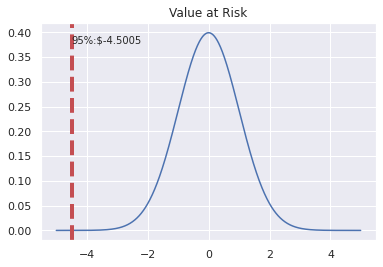

In [2]:
mean = 0
std_dev = 1
x = np.arange(-5, 5, 0.01)
# Генерация функции плотности вероятности на основе заданных значений x, среднего значения и стандартного отклонения
y = norm.pdf(x, mean, std_dev)
pdf = plt.plot(x, y)
# Ограничение осей x и y
min_ylim, max_ylim = plt.ylim()
# Указание местоположения x в 5% процентиле от данных x.
plt.text(np.percentile(x, 5), max_ylim * 0.9, '95%:${:.4f}'
         .format(np.percentile(x, 5)))
plt.axvline(np.percentile(x, 5), color='r', linestyle='dashed',
            linewidth=4)
plt.title('Value at Risk')
plt.show()

Рис.1 Value at Risk: С 95% вероятностью потери от вложений не превысят 4.5$ на определенном временном горизонте.

Для распределения фиансовых показателей, например, для доходностей акций характерны "жирные хвосты" и асимметрия, что не совсем соответствует нормальному распределению. Это эмпирическое наблюдение подразумевает, что доходность акций имеет более высокий эксцесс, чем при нормальном распределении.

Наличие высокого эксцесса равносильно "жирному хвосту", и это может привести к крайне отрицательной доходности. 

Поскольку метод дисперсионно-ковариационного анализа не может охватить "жирный хвост", он, следовательно, не может оценить экстремальную отрицательную доходность, которая, вероятно, произойдет, особенно в кризисный период.

Обозначив ограничение Дисперсионно-ковариационного метода, применим его на  портфеле из 3х активов. 

Формула дисперсии-ковариации VaR для 2х активов выглядит следующим образом:

${VaR = V\sigma_p\sqrt{t}Z_\alpha}$

${\sigma_p} = \sqrt{\omega_1^2\sigma_1^2 + \omega_2^2\sigma_2^2 + \rho\omega_1\sigma_1\omega_2\sigma_2}$

${\sigma_p} = \sqrt{\omega_1^2\sigma_1^2 + \omega_2^2\sigma_2^2 + 2\omega_1\omega_2{cov(\sigma_1\sigma_2)}}$

Воспользуемся функцией [TIME_SERIES_DAILY](https://www.alphavantage.co/documentation/#daily) (Alpha Vantage) она возвращает необработанные (по мере торговли) ежедневные временные ряды (данные, дневное открытие, дневной максимум, дневной минимум, дневное закрытие, дневной объем)

[Alpha Vantage](https://www.alphavantage.co/) - *это компания, предоставляющая данные, сотрудничающая с крупнейшими биржами и институтами. Используя Alpha Vantage API, можно получить доступ к ценам на акции с различным временным интервалом - например, внутридневным, дневным, недельным и так далее, фундаментальным показателям акций и информации о рынке Форекс.*

In [3]:
# Определение параметров, которые будут использоваться при извлечении данных из Alpha Vantage. Воспользуемся функцией TIME_SERIES_DAILY 
def getDailyData(symbol):
        parameters = {'function': 'TIME_SERIES_DAILY', 
                      'symbol': symbol,
                      'outputsize':'full',
                      'datatype': 'csv',
                      'apikey': 'D8RVS3K6LXLZGRJH'}
                    
# Создание запроса на веб-сайт Alpha Vantage.
        response = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&apikey=demo&datatype=csv',
                                params=parameters)
# Откроем файл, который находится в текстовом формате.
# Обработаем полученный CSV-файл
        csvText = StringIO(response.text)
        data = pd.read_csv(csvText, index_col='timestamp')
        return data

Применим методы оценки VaR на двух периодах: сначала за 2020г., а затем на кризисном 2007-2009 гг.

Загрузим данные за 2020г.

Пусть портфель состоит из 3х активов: 

* Акции International Business Machines (IBM)
* Акции Microsoft Corporation (MSFT) 
* Акции Intel (INTC)

In [4]:
symbols = ["IBM", "MSFT", "INTC"]
stock3 = []
for symbol in symbols:
    # Перевернем данные, охватывающие период проверки, и добавьте ежедневные цены закрытия акций IBM, MSFT и INTC.
    stock3.append(getDailyData(symbol)[::-1]['close']['2020-01-01':'2020-12-31'])

stocks = pd.DataFrame(stock3).T
stocks.columns = symbols

In [5]:
stocks.head()

,IBM,MSFT,INTC
timestamp,,,
2020-01-02,135.42,160.62,60.84
2020-01-03,134.34,158.62,60.10
2020-01-06,134.10,159.03,59.93
2020-01-07,134.19,157.58,58.93
2020-01-08,135.31,160.09,58.97


### Дисперсионно-ковариационный метод

Дисперсионно-ковариационный метод также известен как параметрический метод, поскольку предполагается, что данные распределены нормально. Метод дисперсионно-ковариационного анализа является обычным явлением из-за этого предположения, однако стоит отметить, что доходность не распределяется нормально. Предположение о параметрической форме делает применение метода дисперсионно-ковариационного анализа практичным и простым в применении.

In [6]:
# Вычисление логарифмической доходности, чтобы пивести распределение доходности активов к нормальному
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()
stocks_returns

,IBM,MSFT,INTC
timestamp,,,
2020-01-03,-0.008007,-0.012530,-0.012238
2020-01-06,-0.001788,0.002581,-0.002833
2020-01-07,0.000671,-0.009160,-0.016827
2020-01-08,0.008312,0.015803,0.000679
2020-01-09,0.010513,0.012416,0.005580
...,...,...,...
2020-12-24,0.006356,0.007797,0.010679
2020-12-28,0.001042,0.009873,0.000000
2020-12-29,-0.008205,-0.003607,0.048112


In [7]:
stocks_returns_mean = stocks_returns.mean()
# Подбор случайных чисел для весов.
weights  = np.random.random(len(stocks_returns.columns))
# Генерация весов акций в портфеле.
weights /= np.sum(weights)
# Вычисление ковариационной матрицы.
cov_var = stocks_returns.cov()
# Нахождение стандартного отклонения портфеля.
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [8]:
# Выведем ковариационную матрицу:
cov_var

,IBM,MSFT,INTC
IBM,0.000672,0.000465,0.000569
MSFT,0.000465,0.000770,0.000679
INTC,0.000569,0.000679,0.001158


In [9]:
# Пусть сумма для инвестирования = 1 млн., c уровенем доверия 95%
initial_investment = 1e6
conf_level = 0.95

In [10]:
def VaR_parametric(initial_investment, conf_level):
    # Вычисление критического значения (Z-score) для определенного значения (conf_level) с использованием функции процентных пунктов (ppf).
    alpha = norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        # Оценка дисперсионно-ковариационной модели VaR.
        VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
        print("Для {} оценка VaR: {} с использованием параметрческого метода"
              .format(i, VaR_param))
    VaR_param = (initial_investment - initial_investment * (1 + alpha))
    print('--' * 25)
    return VaR_param

In [11]:
VaR_param = VaR_parametric(initial_investment, conf_level)
VaR_param

Для IBM оценка VaR: 42898.75763152074 с использованием параметрческого метода
Для MSFT оценка VaR: 41317.09831607749 с использованием параметрческого метода
Для INTC оценка VaR: 43401.84878110711 с использованием параметрческого метода
--------------------------------------------------


array([42898.75763152, 41317.09831608, 43401.84878111])

Учитывая временной горизонт, результат оценки VaR меняется из-за того, что удержание актива в течение более длительного периода делает инвестора более восприимчивым к риску. 

Как показано на рис.2, VaR увеличивается по отношению ко времени выдержки на величину $\sqrt{t}$, где ${t}$ - количество дней, что также отражено в приведенной формуле:

${VaR = V\sigma_p\sqrt{t}Z_\alpha}$

При построении графика на рис.2 был взят 30-дневный период. 

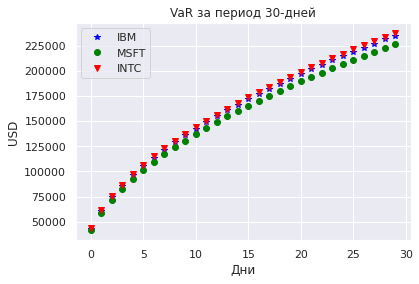

In [12]:
var_horizon = []
time_horizon = 30
for j in range(len(stocks_returns.columns)):
    for i in range(1, time_horizon + 1):
        var_horizon.append(VaR_param[j] * np.sqrt(i))
plt.plot(var_horizon[:time_horizon], "o",
         c='blue', marker='*', label='IBM')
plt.plot(var_horizon[time_horizon:time_horizon + 30], "o",
         c='green', marker='o', label='MSFT')
plt.plot(var_horizon[time_horizon + 30:time_horizon + 60], "o",
         c='red', marker='v', label='INTC')
plt.xlabel("Дни")
plt.ylabel("USD")
plt.title("VaR за период 30-дней")
plt.legend()
plt.show()

Рис.2 VaR в зависимости от периода


## Плюсы и минусы метода дисперсионно-ковариационного анализа.

Плюсы:
* Легко вычисляется
* Для этого не требуется большого количества данных

Минусы
* Наблюдения должны быть распределены нормально
* Он плохо работает с нелинейной структурой
* Требуется вычисление ковариационной матрицы

Таким образом, данный метод не является лучшим способом оценки VaR, особенно в случае, когда доходность активов не имеет нормального распределения. 

# Метод Исторического моделирования

Наличие сильных допущений, таких как нормальное распределение, может быть причиной неточных оценок. Решением этой проблемы является историческое моделирование VaR. Это эмпирический метод: вместо использования параметрического подхода мы находим процентиль, который является эквивалентом Z-таблицы дисперсионно-ковариационного метода. Предположим, что доверительный интервал равен 95%; вместо значений Z-таблицы будет использоваться 5%, и все, что нам нужно сделать, это умножить этот процентиль на первоначальные инвестиции.

Ниже приведены шаги, предпринятые в историческом моделировании VaR:
* Получение доходности активов портфеля (или отдельного актива)
* Нахождение соответствующего процентиля доходности на основе доверительного интервала
* Умножение этого процентиля на первоначальные инвестиции

In [13]:
# Вычисление 95%-ного процентиля доходности акций
def VaR_historical(initial_investment, conf_level):
    Hist_percentile95 = []
    for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
        Hist_percentile95.append(np.percentile(stocks_returns.loc[:, i],
                                               5))
        print("На основе исторических данных 95-му персентилю в распределении доходности {} соответствует {:.4f}"
              .format(i, Hist_percentile95[j]))
        VaR_historical = (initial_investment - initial_investment *
                          (1 + Hist_percentile95[j]))
        print("Для {} оценка VaR: {:.2f} с использованием метода исторического моделирования"
              .format(i, VaR_historical))
        print('--' * 35)

In [14]:
# Оценка исторического моделирования VaR
VaR_historical_20 = VaR_historical(initial_investment,conf_level)

На основе исторических данных 95-му персентилю в распределении доходности IBM соответствует -0.0371
Для IBM оценка VaR: 37081.53 с использованием метода исторического моделирования
----------------------------------------------------------------------
На основе исторических данных 95-му персентилю в распределении доходности MSFT соответствует -0.0426
Для MSFT оценка VaR: 42583.68 с использованием метода исторического моделирования
----------------------------------------------------------------------
На основе исторических данных 95-му персентилю в распределении доходности INTC соответствует -0.0425
Для INTC оценка VaR: 42485.39 с использованием метода исторического моделирования
----------------------------------------------------------------------


Метод исторического моделирования VaR неявно предполагает, что исторические изменения цен имеют аналогичную закономерность, т.е. что *структурного разрыва* нет. Плюсы и минусы этого метода заключаются в следующем:

Плюсы
* Нет предположения о распределении
* Хорошо работает с нелинейными структурами
* Легко вычисляется

Минусы
* Требуется большая выборка
* Требуется высокая вычислительная мощность

# Применим эти методы на данных за период 2007-2009 гг.
### Загрузим данные 

При первом запуске на этом шаге возникает ошибка (ValueError: Index timestamp invalid), она связана с повторной загрузкой данных с alphavantage (насколько удалось разобраться). При последующих попытках данные загружаются.

In [22]:
symbols = ["IBM", "MSFT", "INTC"]
stock3 = []
for symbol in symbols:
    # Перевернем данные, охватывающие период проверки, и добавьте ежедневные цены закрытия акций IBM, MSFT и INTC.
    stock3.append(getDailyData(symbol)[::-1]['close']['2007-04-01': '2009-02-01'])

stocks_crisis = pd.DataFrame(stock3).T
stocks_crisis.columns = symbols

In [23]:
stocks_crisis.head()

,IBM,MSFT,INTC
timestamp,,,
2007-04-02,95.21,27.74,19.13
2007-04-03,96.10,27.87,19.31
2007-04-04,96.21,28.50,19.38
2007-04-05,96.52,28.55,19.58
2007-04-09,96.62,28.57,20.10


In [24]:
stock_prices_cr = stocks_crisis.copy()

In [25]:
stocks_returns_cr = (np.log(stocks_crisis) - np.log(stocks_crisis.shift(1))).dropna()

In [26]:
stocks_returns_cr_mean = stocks_returns_cr.mean()
# Веса активов в портфеле оставим без изменений.
# Вычисление ковариационной матрицы.
cov_var_cr = stocks_returns_cr.cov()
# Нахождение стандартного отклонения портфеля.
port_std_cr = np.sqrt(weights.T.dot(cov_var_cr).dot(weights))

In [27]:
# Выведем ковариационную матрицу:
cov_matrix_cr = stocks_returns_cr.cov()
print(cov_matrix_cr)

           IBM      MSFT      INTC
IBM   0.000405  0.000338  0.000389
MSFT  0.000338  0.000666  0.000512
INTC  0.000389  0.000512  0.000785


In [28]:
def VaR_parametric_cr(initial_investment, conf_level):
    # Вычисление критического значения (Z-score) для определенного значения (conf_level) с использованием функции процентных пунктов (ppf).
    alpha = norm.ppf(1 - conf_level, stocks_returns_cr_mean, port_std_cr)
    for i, j in zip(stocks_returns_cr.columns, range(len(stocks_returns_cr.columns))):
        # Оценка дисперсионно-ковариационной модели VaR.
        VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
        print("Для {} оценка VaR: {} с использованием параметрческого метода"
              .format(i, VaR_param))
    VaR_param = (initial_investment - initial_investment * (1 + alpha))
    print('--' * 25)
    return VaR_param

In [29]:
VaR_param_07= VaR_parametric_cr(initial_investment, conf_level)
VaR_param_07

Для IBM оценка VaR: 37879.93158169638 с использованием параметрческого метода
Для MSFT оценка VaR: 38844.626272965106 с использованием параметрческого метода
Для INTC оценка VaR: 38650.32653423445 с использованием параметрческого метода
--------------------------------------------------


array([37879.9315817 , 38844.62627297, 38650.32653423])

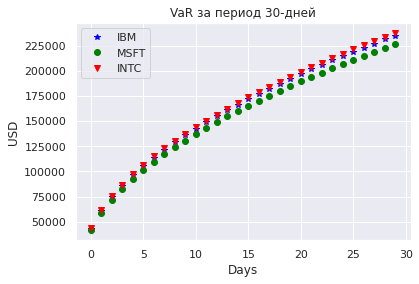

In [30]:
var_horizon = []
time_horizon = 30
for j in range(len(stocks_returns_cr.columns)):
    for i in range(1, time_horizon + 1):
        var_horizon.append(VaR_param[j] * np.sqrt(i))
plt.plot(var_horizon[:time_horizon], "o",
         c='blue', marker='*', label='IBM')
plt.plot(var_horizon[time_horizon:time_horizon + 30], "o",
         c='green', marker='o', label='MSFT')
plt.plot(var_horizon[time_horizon + 30:time_horizon + 60], "o",
         c='red', marker='v', label='INTC')
plt.xlabel("Days")
plt.ylabel("USD")
plt.title("VaR за период 30-дней")
plt.legend()
plt.show()

In [31]:
# Применим метод исторической симуляции для кризисного периода

def VaR_historical_cr(initial_investment, conf_level):
    Hist_percentile95 = []
    for i, j in zip(stocks_returns_cr.columns,
                    range(len(stocks_returns_cr.columns))):
        Hist_percentile95.append(np.percentile(stocks_returns_cr.loc[:, i],
                                               5))
        print("На основе исторических данных 95-му персентилю в распределении доходности {} соответствует {:.4f}"
              .format(i, Hist_percentile95[j]))
        VaR_historical = (initial_investment - initial_investment *
                          (1 + Hist_percentile95[j]))
        print("Для {} оценка VaR: {:.2f} с использованием метода исторического моделирования"
              .format(i, VaR_historical))
        print('--' * 35)

In [32]:
VaR_historical_07 = VaR_historical(initial_investment,conf_level)

На основе исторических данных 95-му персентилю в распределении доходности IBM соответствует -0.0371
Для IBM оценка VaR: 37081.53 с использованием метода исторического моделирования
----------------------------------------------------------------------
На основе исторических данных 95-му персентилю в распределении доходности MSFT соответствует -0.0426
Для MSFT оценка VaR: 42583.68 с использованием метода исторического моделирования
----------------------------------------------------------------------
На основе исторических данных 95-му персентилю в распределении доходности INTC соответствует -0.0425
Для INTC оценка VaR: 42485.39 с использованием метода исторического моделирования
----------------------------------------------------------------------


В этом блокноте представлены примеры расчета VaR для портфеля из 3х акций за два периода. Расчет производился 2мя методами: параметрическим и методом исторического моделирования.